chi-squared:  42.0001218866


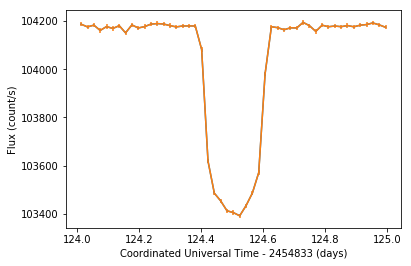

In [171]:
%matplotlib inline
import math
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plot
from astropy.stats import sigma_clip

"""
   Some functions of use for Calculating Transit light curves
"""

#
# This implements the planet obscuration function for a uniform
#  (stellar) disk described in Mandel & Agol (2002).
#  http://dx.doi.org/10.1086/345520
# 

def kappa0(p, z):
    return math.acos((p**2 + z**2 - 1)/(2*p*z))

def kappa1(p, z):
    return math.acos((1 - p**2 + z**2)/(2*z))

def lambd(p, z):
    if 1 + p < z:
        return 0
    if z <= 1 - p:
        return p**2
    if z <= p - 1:
        return 1
    arg = (4*z**2 - (1 + z**2 - p**2)**2)/4
    if arg >= 0:
        return (kappa0(p, z)*p**2 + kappa1(p, z) - math.sqrt(arg))/math.pi
    else:
        return 0

def FluxRatio(p, z):
    """
    Compute the ratio of obscured/unobscured flux for a planet transit.
    
    Arguments:
       p - ratio of planet radius to stellar radius
       z - distance between star and planet divided by stellar radius
    Returns: 
       FluxRatio - ratio of obscured to unobscured stellar flux
    """
    return 1 - lambd(p, abs(z))

# The following functions are used in computing the transit light curve
#

def beta(p, r, z):
    return 2.0 * math.acos((z**2 - p**2 + r**2)/(2*z*r))

def delta(p, r, z):
    """
    Compute the ratio of obscured/unobscured flux for a planet transit
       for a given radial ring.
    
    Arguments:
       p - ratio of planet radius to stellar radius
       r - radius of ring (divided by stellar radius)
       z - distance between star and planet divided by stellar radius
    Returns: 
       delta - ratio of obscured to unobscured stellar flux for that radius
    """
    if r >= z + p or r <= z - p:
        return 0
    if r + z <= p:
        return 1
    b = beta(p, r, z)
    return b/(2*math.pi)

def I(r):
    '''A Limb-darkening function'''
    mu = (1.0 - (r**2))**(0.5)
    return 1.0 - (1.0 - (mu**(0.5)))

def func1(r, p = p, z = zval):
        return I(r) * (1.0 - delta(p,r,abs(z))) * 2.0 * r
    
def func2(r):
        return I(r) * 2.0 * r

def chi_sq(f1, f2, sig):
    n = len(f1)
    total = 0
    for i in range(n):
        a = ((f1[i] - f2[i])/sig)**2
        total = total + a
    return total

def fmean(f):
    total = 0
    for i in range(len(f)):
        total = total + f[i]
    return (total)/len(f)

def fsd(f):
    return np.std(f)

def normalize(f):
    f1 = []
    fbar = fmean(f)
    sig = fsd(f)
    for i in f:
        if abs(i - fbar)/sig <= 2.0:
            f1.append(i)
    return f1

# Find the target KOI.
client = kplr.API()
koi = client.koi(97.01)

# Get a list of light curve datasets.
lcs = koi.get_light_curves(short_cadence=False)

# Open the first dataset and read it
f = lcs[0].open()
#this is the first dataset
hdu_data = f[1].data
time = hdu_data["time"] #get time of observation
flux = hdu_data["sap_flux"]
flux_err = hdu_data["sap_flux_err"]
f.close()

eclipse_index = np.where((125>time)&(time>124))
eclipse_t = time[eclipse_index]
eclipse_f = flux[eclipse_index]
eclipse_ferr = flux_err[eclipse_index]

f1 = []
t1 = []
e1 = []
for i in range(0, len(eclipse_f)):
    f1.append(eclipse_f[i])
    t1.append(eclipse_t[i])
    e1.append(eclipse_ferr[i]) 

for i in range(5):
    #find the average
    Fbar = fmean(f1)

    #find standard dev
    sigma_prime = fsd(f1)

    #removing the transit
    for i in range(0, len(f1)):
        if (abs(f1[i] - Fbar)/sigma_prime) > 2:
            f1[i] = 0
            t1[i] = 0
            e1[i] = 0
#print("flux excluding the transit: ", f1)
#now we have the flux excluding the transit
#find the average of this

nf = []
nt = []
ne = []
for i in range(len(f1)):
    if f1[i] > 0:
        nf.append(f1[i])
        nt.append(t1[i])
        ne.append(e1[i])
        
avgf = fmean(nf)

#find standard dev
sigma_prime = fsd(nf)
sigma_norm = sigma_prime/avgf

normalized_f = nf/avgf

normalized_err = ne/avgf

#ratio of obscured to unobscured:
p = 0.0775
tau = 0.1 
t0 = 124.51

z = []
for tval in t1:
    z.append((tval-t0)/tau)

flux_predicted = np.zeros(len(z))
for i in range(len(z)):
    zval = z[i]
    top = integrate.quad(func1, 0, 1)
    bottom = integrate.quad(func2, 0, 1)
    flux_predicted[i] = top[0]/bottom[0]
chi = chi_sq(normalized_f, flux_predicted, sigma_norm)
print("chi-squared: ", chi)

plot.plot(eclipse_t, eclipse_f)
plot.errorbar(eclipse_t, eclipse_f, yerr=eclipse_ferr)
plot.xlabel("Coordinated Universal Time - 2454833 (days)")
plot.ylabel("Flux (count/s)")
plot.show()

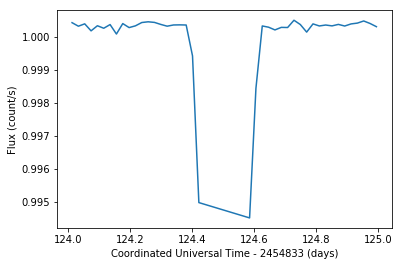

In [172]:
plot.plot(nt, normalized_f)
#print(len(nt), len(nf), len(normalized_err))
#plot.errorbar(nt, nf, yerr=sigma_norm)
#plot.plot(t1, f1, 'o')
plot.xlabel("Coordinated Universal Time - 2454833 (days)")
plot.ylabel("Flux (count/s)")
plot.show()

Problem 3

best tau:  0.1
new chi:  42.0001218866


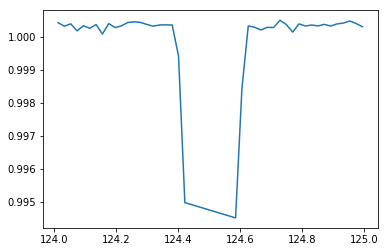

In [180]:
tau1 = tau
chi1 = chi

for i in np.arange(.08, .13, .01):
    z = []
    for tval in nt:
        z.append((tval-t0)/tau1)
    flux_predicted = np.zeros(len(z))
    for i in range(len(z)):
        zval = z[i]
        top = integrate.quad(func1, 0, 1)
        bottom = integrate.quad(func2, 0, 1)
        flux_predicted[i] = top[0]/bottom[0]
    
    chi = chi_sq(normalized_f, flux_predicted, sigma_norm)
    if chi < chi1:
        tau1 = i
        chi1 = chi
print("best tau: ", tau1)
print("new chi: ", chi1)
plot.plot(nt, normalized_f)
plot.show()

Problem 4

In [ ]:
tau1 = tau
chi1 = chi

for tau in np.arange(.08, .13, .01):
    z = []
    for tval in nt:
        z.append((tval-t0)/tau1)
    flux_predicted = np.zeros(len(z))
    for i in range(len(z)):
        zval = z[i]
        top = integrate.quad(func1, 0, 1)
        bottom = integrate.quad(func2, 0, 1)
        flux_predicted[i] = top[0]/bottom[0]
    
    chi = chi_sq(normalized_f, flux_predicted, sigma_norm)
    if chi < chi1:
        tau1 = i
        chi1 = chi
for p in np.arange(0.0665, 0.0885, 0.005):
        